In [1]:
%load_ext autoreload
%autoreload 2

from functools import partial
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import seaborn as sns
import sys
import torch
from torch import Tensor
from typing import *

from sparq_benchmark import benchmark_call, gather
import gather_matmul as G

sns.set_context("notebook")

# Run benchmark

In [2]:
def reference_gather_inner_bmv(a: Tensor, b: Tensor, i: Tensor) -> Tensor:
    return a @ gather(b, 1, i[:, :, None])

def reference_slice_inner_bmv(a: Tensor, b: Tensor, i: Tensor) -> Tensor:
    return a @ b[:, : i.shape[1], :]

def run_benchmark(g: int, k_pre: int, k: int, n: int, dtype: str,
                  method: str, transpose_B: bool, chunk: Optional[int]) -> Dict[str, Any]:
    device, dtype_ = torch.device("cuda"), getattr(torch, dtype)
    config = dict(
        g=g, k_pre=k_pre, k=k, n=n, dtype=dtype,
        method=method, transpose_B=transpose_B, chunk=chunk,
    )
    try:
        A = torch.randn(g, 1, k, device=device, dtype=dtype_)
        B = torch.randn(g, k_pre, n, device=device, dtype=dtype_)
        if transpose_B:
            B = B.transpose(-1, -2).contiguous().transpose(-1, -2)
        I = torch.randint(0, k_pre, (g, k), device=device)
        method_fn = dict(
            torch=partial(reference_gather_inner_bmv, A, B, I),
            slice=partial(reference_slice_inner_bmv, A, B, I),
            custom=partial(G.gather_inner_matrix_only_bmv, A, B, I, chunk=chunk),
        )[method]
        times = benchmark_call(
            method_fn, reps=100, warmup=10, device=device, pre_fn=lambda: torch.randint(0, k_pre, I.shape, out=I)
        )
        return dict(
            **config, time=float(times.mean()), time_stderr=float(times.std() / len(times)**.5),
            device=torch.cuda.get_device_name(),
        )
    except Exception as error:
        print(f"Failed config {config} {error}", file=sys.stderr)

In [10]:
torch.seed()

# Sweep around SparQ's final KV matmul
df = pd.DataFrame.from_dict(filter(None, [
    run_benchmark(g=g, k_pre=k_pre, k=k, n=128, dtype="float16",
                  method=method, transpose_B=False, chunk=chunk)
    for g in [256, 1024, 4096]
    for k_pre in [1024, 4096, 16384]
    for k in [64, 128, 256, 512]
    for method in ["torch", "slice", "custom"]
    for chunk in (map(int, 2**torch.arange(0, 9)) if method == "custom" else [None])
    if not (g >= 2048 and k_pre >= 16384)  # unrecoverable error
]))

def bytes_transferred(s: pd.Series) -> float:
    bytes_per_param = dict(float16=2, float32=4)[s["dtype"]]
    return s.g * (2 * s.k + s.k * s.n + s.n) * bytes_per_param

df["bytes_transferred"] = df.apply(bytes_transferred, axis=1)
df["effective_bandwidth"] = df.bytes_transferred / df.time
df.to_json("../out/gather_matmul_benchmark/gather_inner_matrix_only_bmv.json")

# 1. A good default `chunk=min(64, 8192//k)`

In [11]:
device_name, = df.device.unique()
expected_memory_bandwidth = {  # B/s
    "NVIDIA A10G": 600e9,
}[device_name]
best = (
    df.pipe(lambda d: d[d.method == "custom"])
    .groupby(["g", "k_pre", "k"])
        .apply(lambda s: s.iloc[s.effective_bandwidth.argmax()][["bytes_transferred", "chunk", "effective_bandwidth"]])
        .reset_index()
)

print("Best chunk size:")
display(best.pivot_table(index=["g"], columns=["k_pre", "k"], values="chunk")
        .style.format(lambda x: "" if pd.isna(x) else f"{x:.0f}"))

print("Achieved bandwidth:")
display(best.pivot_table(index=["g"], columns=["k_pre", "k"], values="effective_bandwidth")
        .style
        .format(lambda x: "" if pd.isna(x) else f"{x/1e9:.0f}")
        .background_gradient("flare_r", vmin=0, vmax=expected_memory_bandwidth))

Best chunk size:


Achieved bandwidth:


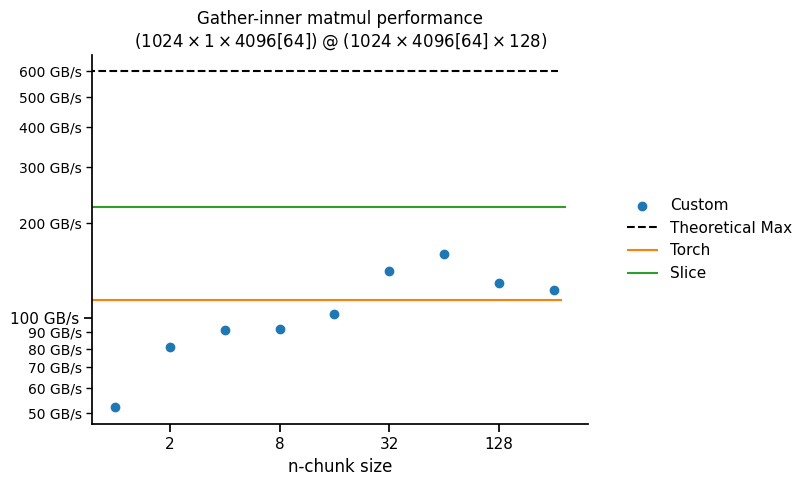

In [45]:
g, k_pre, k = 1024, 4096, 64
d = df.pipe(lambda d: d[(d.g == g) & (d.k_pre == k_pre) & (d.k == k)])
ax = plt.gca()
colors = iter(sns.color_palette())
ax.scatter(d.chunk, d.effective_bandwidth, color=next(colors), label="Custom")
ax.hlines(expected_memory_bandwidth, *ax.get_xlim(), "k", "--", label="Theoretical Max")
for method in ["torch", "slice"]:
    ax.hlines(d[d.method==method].effective_bandwidth, *ax.get_xlim(), next(colors), label=method.capitalize())
ax.set_xscale("log", base=2)
ax.set_yscale("log", base=10)
ax.xaxis.set_major_formatter("{x:.0f}")
ax.set_xlabel("n-chunk size")
ax.set_title(f"Gather-inner matmul performance\n$({g} \\times 1 \\times {k_pre}[{k}]) \;@\; ({g} \\times {k_pre}[{k}] \\times 128)$")
ax.legend(loc="center left", bbox_to_anchor=(1.05, 0.5), frameon=False)
ax.yaxis.set_major_formatter(lambda x, _: f"{x/1e9:.0f} GB/s")
ax.yaxis.set_minor_formatter(lambda x, _: f"{x/1e9:.0f} GB/s")
ax.tick_params(axis="y", which="minor", labelsize=10)
sns.despine(ax=ax)

# 2. The implementation has room for improvement; performance depends on {`g`, `k_pre`, `k`}

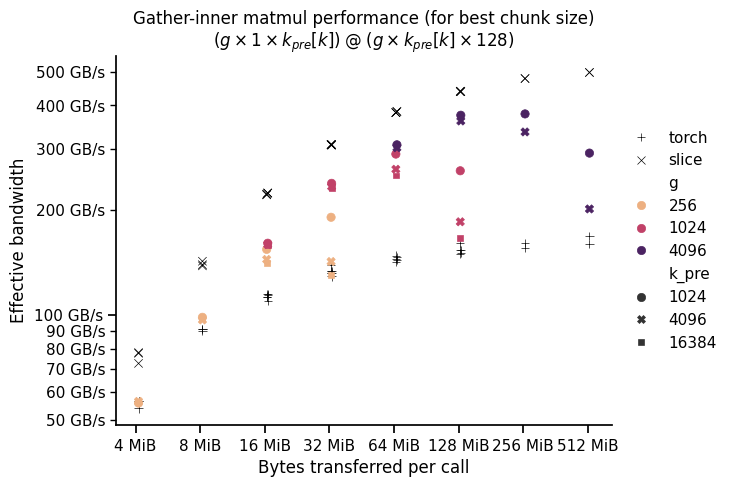

In [41]:
ax = sns.scatterplot(data=df[df.method!="custom"], y="effective_bandwidth", x="bytes_transferred", style="method",
                     color="k", edgecolor=None, markers=dict(torch="+", slice="x"))
sns.scatterplot(data=best, y="effective_bandwidth", x="bytes_transferred", hue="g", style="k_pre", hue_norm=matplotlib.colors.LogNorm(),
                palette="flare", edgecolor=None)
ax.set_xscale("log", base=2)
ax.set_yscale("log")
ax.set_ylabel("Effective bandwidth")
ax.set_xlabel("Bytes transferred per call")
ax.set_title(f"Gather-inner matmul performance (for best chunk size)\n$(g \\times 1 \\times k_{{pre}}[k]) \;@\; (g \\times k_{{pre}}[k] \\times 128)$")
ax.yaxis.set_major_formatter(lambda x, _: f"{x/1e9:.0f} GB/s")
ax.yaxis.set_minor_formatter(lambda x, _: f"{x/1e9:.0f} GB/s")
ax.yaxis.set_major_formatter(lambda x, _: f"{x/1e9:.0f} GB/s")
ax.xaxis.set_major_formatter(lambda x, _: f"{x/2**20:.0f} MiB")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, frameon=False, bbox_to_anchor=(1, 0.5), loc="center left")
sns.despine(ax=ax)